In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import metrics
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import Callback
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Processing

In [ ]:
!unzip /content/drive/MyDrive/ifood-2019-fgvc6.zip

Streaming output truncated to the last 5000 lines.
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_007118.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_007118.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_000306.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_000306.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_000060.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_000060.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_003031.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_003031.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_009643.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_009643.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_003805.jpg  
  inflating: __MACOSX/ifood-2019-fgvc6/organized_val_set/46/._val_003805.jpg  
  inflating: ifood-2019-fgvc6/organized_val_set/46/val_003581.jpg  

In [ ]:
num_classes = 251
width, height = 224, 224
train_dir = '/content/ifood-2019-fgvc6/organized_train_set'
val_dir = '/content/ifood-2019-fgvc6/organized_val_set'
test_dir = '/content/ifood-2019-fgvc6/test_set'
batch_size = 32

In [ ]:
csv_path = '/content/drive/MyDrive/train_incorrect.csv'

incorrect_images_df = pd.read_csv(csv_path, header=None)
incorrect_images = incorrect_images_df[0].tolist()  # Access the first (and only) column

for root, dirs, files in os.walk(train_dir):  # Traverse through all class subdirectories
    for img_file in incorrect_images:
        img_path = os.path.join(root, img_file)
        if os.path.exists(img_path):
            os.remove(img_path)
            print(f"Removed {img_file} from {root}")
        #else:
           # print(f"{img_file} not found in {root}")

Removed train_039694.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039698.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039699.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039701.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039712.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039716.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039733.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039739.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039754.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039774.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039782.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039784.jpg from /content/ifood-2019-fgvc6/organized_train_set/103
Removed train_039787.jpg from /content/i

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    validation_split=0.3,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
)

val_set = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(width, height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
)

Found 114154 images belonging to 251 classes.
Found 11994 images belonging to 251 classes.


In [ ]:
# Get a list of all class directories
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Count the number of images in each class directory
class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in class_dirs]

# Plot the frequency of image counts using a histogram
plt.figure(figsize=(10, 6))
plt.hist(class_counts, bins=20, color='skyblue', edgecolor='black')

plt.title('Frequency Distribution of Image Counts per Class', fontsize=16)
plt.xlabel('Number of Images per Class', fontsize=12)
plt.ylabel('Frequency of Classes', fontsize=12)

plt.tight_layout()

plt.show()

In [ ]:
from sklearn.utils import class_weight

class_labels = train_set.classes  # Labels for each image in the training set

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(class_labels),
                                                  y=class_labels)

# Keras requires dict format
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7323620173091852, 1: 0.8564911727853183, 2: 1.4212400398406375, 3: 1.060132430650359, 4: 0.915084130279686, 5: 0.8406595429741294, 6: 1.7492185105730922, 7: 0.9951790213326126, 8: 0.963552569383483, 9: 0.9514577672573306, 10: 0.9281567607122531, 11: 1.1174368863611892, 12: 1.3455527004408403, 13: 0.7950993229877692, 14: 1.062609375581785, 15: 0.8900133321898317, 16: 0.8746092552865461, 17: 1.0479189233848019, 18: 0.9615154603573023, 19: 0.79095097869392, 20: 20.672582397682, 21: 0.7395070126000065, 22: 0.8092469977740284, 23: 0.7443483023715286, 24: 0.7517302690066181, 25: 0.8150480515215125, 26: 1.252883781677697, 27: 0.9865440623622647, 28: 0.8662796433314361, 29: 0.8485015163227686, 30: 1.0701101476447152, 31: 0.9059697465119602, 32: 1.075169770092208, 33: 1.2325116876666775, 34: 0.804950111060184, 35: 1.0958959343349493, 36: 0.8746092552865461, 37: 1.1572437983435215, 38: 0.9844086856039047, 39: 1.075169770092208, 40: 1.1661456737153948, 41: 1.0407249719656841,

# Model Callbacks

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Pre-Trained-Tests'
os.makedirs(checkpoint_dir, exist_ok=True)

# Get the current timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Callbacks
Callbacks = [
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, f'DenseNet201_Best_{timestamp}.keras'),
                    save_best_only=True,
                    monitor='val_loss',
                    mode='min',
                    save_weights_only=False,
                    verbose=1),  # Save the best model based on validation loss
    EarlyStopping(monitor='val_loss',
                  patience=10,  # Stop training after 10 epochs without improvement
                  mode='min',
                  verbose=1,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.2,  # Reduce learning rate by 20%
                      patience=3,  # Reduce if no improvement after 3 epochs
                      mode='min',
                      verbose=1),
]

In [ ]:
class SaveHistory(Callback):

    def __init__(self, save_path):

        super(SaveHistory, self).__init__()

        self.save_path = save_path

        # Load history if exists
        if os.path.exists(self.save_path):

            with open(self.save_path, 'rb') as f:
                self.history = pickle.load(f)

        else:
            self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'precision': [], 'val_precision': [], 'recall': [], 'val_recall': []}

    def on_epoch_end(self, epoch, logs=None):
        # Append new logs to the existing history
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['precision'].append(logs.get('precision'))
        self.history['val_precision'].append(logs.get('val_precision'))
        self.history['recall'].append(logs.get('recall'))
        self.history['val_recall'].append(logs.get('val_recall'))

        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(self.save_path), exist_ok=True)

        # Save history to a file
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

        print(f"Epoch {epoch+1} history saved to {self.save_path}")

# Create a unique filename with a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
history_save_path = f'/content/drive/MyDrive/Pre-Trained-Tests/DenseNet201_Training_{timestamp}.pkl'

# Create the callback
history_callback = SaveHistory(save_path=history_save_path)


# DenseNet201 Model Testing

In [ ]:
resnet = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False,input_shape=(width,width,3))
for layer in resnet.layers[:150]:
     layer.trainable=False

In [ ]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(300,activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=output)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 18,973,835 (72.38 MB)

 Trainable params: 11,939,787 (45.55 MB)

 Non-trainable params: 7,034,048 (26.83 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

history = model.fit(train_set,
                      validation_data=val_set,
                      epochs=20,
                      verbose=1,
                      class_weight=class_weights_dict,
                      callbacks=[Callbacks, history_callback])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3568/3568 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.1091 - loss: 4.6873 - precision: 0.5650 - recall: 0.0213
Epoch 1: val_loss improved from 5.52427 to 2.25896, saving model to /content/drive/MyDrive/Pre-Trained-Tests/DenseNet201_Best_20241127-020554.keras
Epoch 1 history saved to /content/drive/MyDrive/Pre-Trained-Tests/DenseNet201_Training_20241127_020635.pkl
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 1509s 383ms/step - accuracy: 0.1091 - loss: 4.6871 - precision: 0.5650 - recall: 0.0213 - val_accuracy: 0.4701 - val_loss: 2.2590 - val_precision: 0.7759 - val_recall: 0.2632 - learning_rate: 1.0000e-04
Epoch 2/20
3568/3568 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.3508 - loss: 2.9692 - precision: 0.7164 - recall: 0.1620
Epoch 2: val_loss improved from 2.25896 to 1.84952, saving model to /content/drive/MyDrive/Pre-Trained-Tests/DenseNet201_Best_20241127-020554.keras
Epoch 2 history saved to /content/drive/MyDrive/Pre-Trained-Tests/DenseNet201_Training_20241127_020635.pkl
3568/3568 ━━━

# Model Results Evalutation

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Pre-Trained-Tests/DenseNet201_Best_20241127-020554.keras')
y_true = val_set.classes
prediction = loaded_model.predict(val_set)
y_pred = np.argmax(prediction, axis=1)

label_map = {}
with open('/content/ifood-2019-fgvc6/class_list.txt', 'r') as f:
    for line in f:
        numerical_label, actual_label = line.strip().split()
        label_map[int(numerical_label)] = actual_label

y_true_mapped = [label_map[label] for label in y_true]
y_pred_mapped = [label_map[label] for label in y_pred]


print("Sample of y_true:", y_true_mapped[:10])
print("Sample of y_pred:", y_pred_mapped[:10])

# Generate the classification report
report = classification_report(y_true_mapped, y_pred_mapped, zero_division=1)
print(report)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 121ms/step
Sample of y_true: ['macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron']
Sample of y_pred: ['macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron', 'macaron']
                               precision    recall  f1-score   support

                        adobo       0.28      0.28      0.28        40
                ambrosia_food       0.56      0.48      0.51        42
                    apple_pie       0.78      0.86      0.82        44
               apple_turnover       0.43      0.56      0.48        43
                   applesauce       0.33      0.21      0.26        33
              applesauce_cake       0.54      0.49      0.51        57
                baby_back_rib       0.51      0.51      0.51        35
               bacon_and_eggs       0.75      0.82      0.78        57
bacon_lettuce_tomato_sandwich       0.66      0.90      0.

In [ ]:
result = loaded_model.evaluate(val_set)
print("\nTest Loss:", result[0])
print("Test Accuracy:", result[1])
print("Test Precision:", result[2])
print("Test Recall:", result[3])

375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.6357 - loss: 1.4963 - precision: 0.7780 - recall: 0.5576

Test Loss: 1.506204605102539
Test Accuracy: 0.6315658092498779
Test Precision: 0.7658418416976929
Test Recall: 0.552192747592926


In [ ]:
class_labels = list(val_set.class_indices.keys())

test_images, test_labels = next(val_set)
predictions = loaded_model.predict(test_images)

for i in range(20):
    predicted_label_index = np.argmax(predictions[i])
    predicted_label = class_labels[predicted_label_index]
    true_label_index = np.argmax(test_labels[i])
    true_label = class_labels[true_label_index]

    plt.figure(figsize=(2,2))
    plt.imshow(test_images[i])
    plt.title(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}")
    plt.axis('off')
    plt.show()

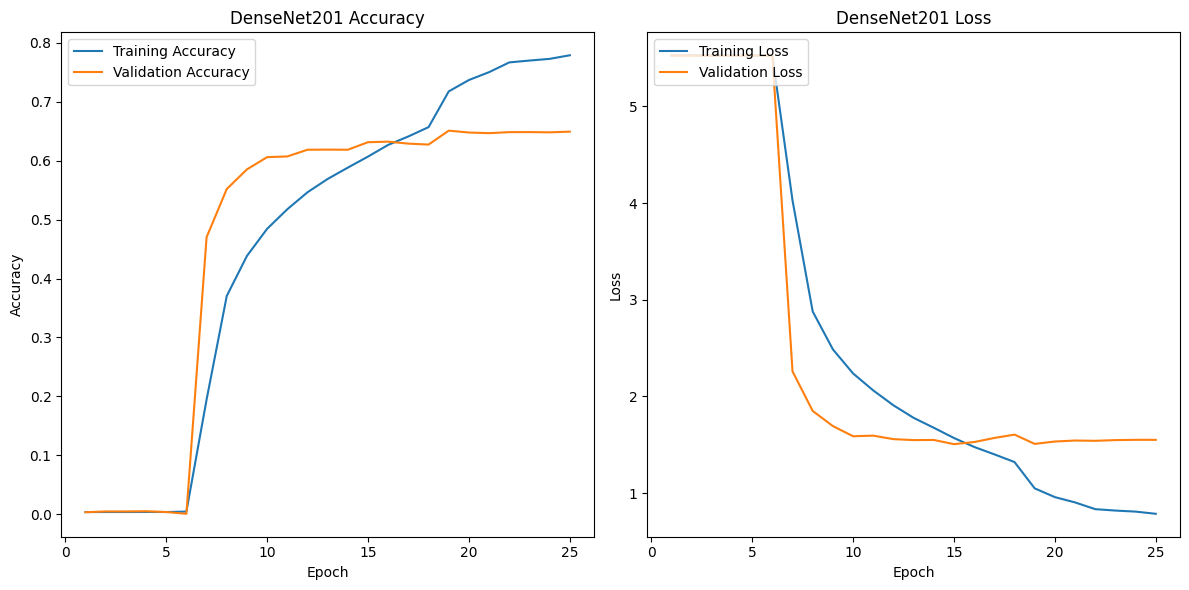

In [ ]:
with open('/content/drive/MyDrive/Pre-Trained-Tests/DenseNet201_Training_20241127_020635.pkl', 'rb') as file:
    history1 = pickle.load(file)

epochs = np.arange(1, len(history1['loss']) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history1['accuracy'], label='Training Accuracy')
plt.plot(epochs, history1['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet201 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, history1['loss'], label='Training Loss')
plt.plot(epochs, history1['val_loss'], label='Validation Loss')
plt.title('DenseNet201 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
